In [28]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 1. Read and process the pickle file

In [29]:
with open('../tracker_stubs/ball_detections.pkl','rb') as f:
    ball_positions = pickle.load(f)

In [30]:
ball_positions = [x.get(1, []) for x in ball_positions]

df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2']).interpolate().bfill()

In [31]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

Here is the ball's center mean

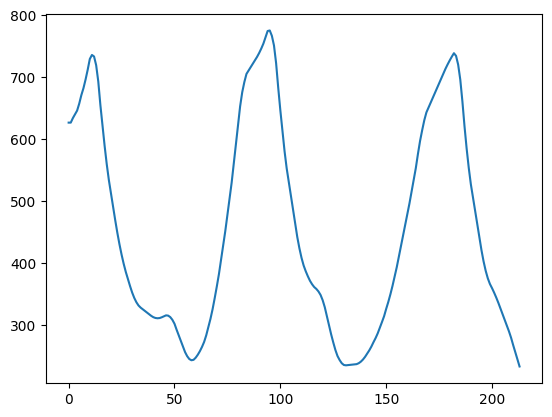

In [32]:
plt.plot(df_ball_positions['mid_y_rolling_mean'])

As we can notice from the previous plot, the spikes in the graph are representing the moments when the ball was hit => changed its trajectory

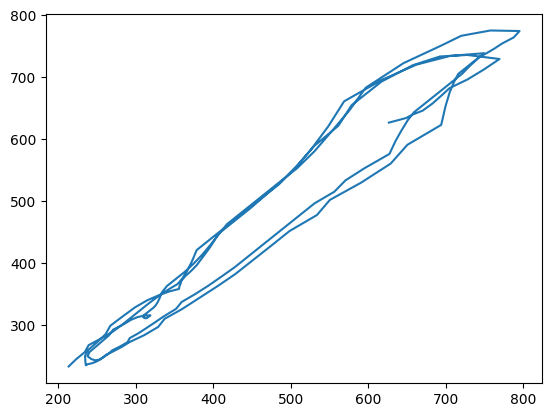

In [33]:
plt.plot(df_ball_positions['mid_y'], df_ball_positions['mid_y_rolling_mean'])

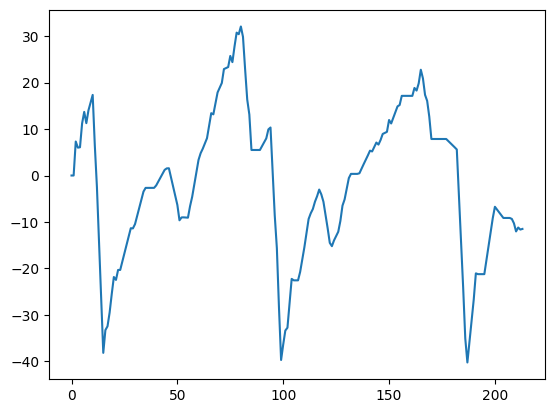

In [34]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff().fillna(0)
plt.plot(df_ball_positions['delta_y'])

In [35]:
df_ball_positions['ball_hit'] = 0

### 2. Identify the frames when the ball is actually hit by the players

In [36]:
minimum_change_frames_for_hit = 25
window = int(minimum_change_frames_for_hit * 1.2)

for i in range(1, len(df_ball_positions) - window):
    neg_changes = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0
    pos_changes = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0

    if neg_changes or pos_changes:
        changes = 0
        for change_frame in range(i+1, i + window + 1):
            neg_changes_next = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0
            pos_changes_next = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0

            if neg_changes and neg_changes_next:
                changes += 1
            elif pos_changes and pos_changes_next:
                changes += 1

        if changes >= minimum_change_frames_for_hit:
            df_ball_positions['ball_hit'].iloc[i] = 1
            

C:\Users\danie\AppData\Local\Temp\ipykernel_11588\3463979409.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
C:\Users\danie\AppData\Local\Temp\ipykernel_11588\3463979409.py:20: SettingWithCopyWa

In [37]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]


,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,776.866150,717.329407,796.805603,738.391846,727.860626,735.918506,6.523041,1
58,925.881812,240.970572,939.040649,253.989804,247.480188,243.406055,-1.957917,1
95,624.777618,748.892639,642.158173,766.700287,757.796463,775.404471,0.871909,1
131,716.963684,229.096046,729.237244,242.786385,235.941216,235.241810,-0.557025,1
182,1294.893799,739.124634,1314.162354,760.560425,749.842529,738.733170,5.601654,1


In [ ]:
frames_ball_was_hit = df_ball_positions.index[df_ball_positions['ball_hit'] == 1].tolist()
frames_ball_was_hit

[11, 58, 95, 131, 182]